In [1]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
from framework import *
import pandas as pd
import time
# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)

ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Using TensorFlow backend.


Set up the task details. This notebook handles NER (for labeling person and company names)

In [2]:
DATASET = 'omf-paystubs' # supports w2 and resume
TASK_CONFIG = {
    'task': 'cmp_name',
}

task = Task(TASK_CONFIG)

Set paths for datasets and goldens (local or ib, both work).
Specify configurations

In [3]:
OMF_DATA = [
    'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch2/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch3/out/s1_process_files/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch4/out/s1_process_files/'
]
OMF_GOLDEN = [
    './omf_batch_1.csv',
    # './omf_batch_2.csv',
    # './omf_batch_3.csv',
    # './omf_batch_4.csv'
]

GOLDEN_CONFIG = {
    'path': OMF_GOLDEN,
    'is_local': True,
    'index_field_name':'filename',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': OMF_DATA,
    'is_local': False, 
    'file_type': 'ibdoc',
    'identifier': lambda path: os.path.basename(path).split('.ibdoc')[0],
    'convert2txt': False
}


data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/
INFO:root:101 files loaded
INFO:root:Loading goldens from ./omf_batch_1.csv
INFO:root:Goldens have non-unique filenames, keeping only the first values
INFO:root:Total files Goldens: (117, 17)
INFO:root:Total files found in the source with unique index: (101, 17)


In [4]:
# ToDo: add ModelSelection() hyperparameter search in the framework

DATA_ARGS = {
    'task': task,
    'dataset': data,
    'data_config': {
        'max_num_tokens': 5,
        'max_token_distance': None,
        'embedding_type': 'bert',
        'cardinal_only': False,
        'balance_targets': True,
        'additional_features': [],
        'pre_processing': ['lower_case', 'remove_punc']
    }
}

TRAINING_ARGS = {
    'batch_size': 32,
    'epochs': 25, 
}


fe = FeatureEngineering_MLP(DATA_ARGS)
samples = fe.create_train_test_data()
print('Input shape: {}'.format(samples[0].shape))

model = MLP(DATA_ARGS, TRAINING_ARGS)

INFO:root:Building BERT Model embeddings using pretrained model
INFO:root:Finished Loading Model, computing embeddings
Input shape: (578, 31488)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
INFO:root:Training multilayer perceptron model for 578 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Train on 578 samples, validate on 248 samples
Epoch 1/25
578/578 [==============================] - 3s 6ms/step - loss: 2.4438 - accuracy: 0.5848 - val_loss: 1.0732 - val_accuracy: 0.7137
Epoch 2/25
578/578 [==============================] - 4s 6ms/step - loss: 1.7009 - accuracy: 0.6869 - val_loss: 0.5623 - val_accuracy: 0.7460
Epoch 3/25
578/578 [==============================] - 3s 5ms/step - loss: 1.1673 - accuracy: 0.7111 - val_loss: 0.5558 - val_accuracy: 0.7016
Epoch 4/25
578/578 [==============================] - 3s 6ms/step - loss: 0.8266 - accuracy: 0.7318 - val_loss: 0.4797 - val_accuracy: 0.7863
Epoch 5/25
578/578 [==============================] - 3s 6ms/step - loss: 0.5316 - 

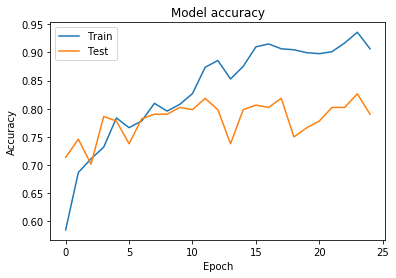

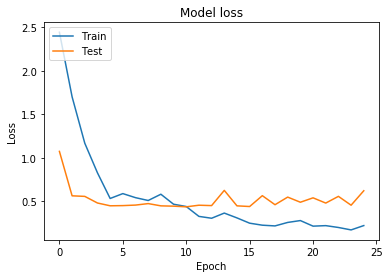

INFO:root:Accuracy is 0.7903226017951965


In [5]:
model.train(*samples)
acc = model.evaluate()
logging.info("Accuracy is {}".format(acc))

In [6]:
found_companies = model.predict()
print(found_companies)

KeyboardInterrupt: 

In [ ]:
model.calculate_recall(found_companies)
model.demo()